In [ ]:
pip install seaborn

In [1]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch 

torch.cuda.is_available()

True

In [3]:
df = pd.read_csv('tiktokpre2.csv')
df.head()

,content,sentiment
0,tolong keuangan transfer rekening berbeda reke...,negative
1,sumpah ya aplikasi seller buruk tuh duitnya la...,negative
2,susah ribet,negative
3,capai bikin dekripsi tolak kacau,negative
4,pelanggaran upload barang,negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145 entries, 0 to 3144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    3145 non-null   object
 1   sentiment  3145 non-null   object
dtypes: object(2)
memory usage: 49.3+ KB


In [5]:
# Mengganti nama kolom
df = df.rename(columns={'content': 'review'})

In [6]:
df.head()

,review,sentiment
0,tolong keuangan transfer rekening berbeda reke...,negative
1,sumpah ya aplikasi seller buruk tuh duitnya la...,negative
2,susah ribet,negative
3,capai bikin dekripsi tolak kacau,negative
4,pelanggaran upload barang,negative


In [7]:
# Label encoding dengan inplace=True
df['sentiment'].replace({'positive': 1, 'negative': 0}, inplace=True)
df.head()

,review,sentiment
0,tolong keuangan transfer rekening berbeda reke...,0
1,sumpah ya aplikasi seller buruk tuh duitnya la...,0
2,susah ribet,0
3,capai bikin dekripsi tolak kacau,0
4,pelanggaran upload barang,0


In [8]:
frequency = df['sentiment'].value_counts()
print(frequency)

sentiment
0    1755
1    1390
Name: count, dtype: int64


In [9]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [10]:
print("Jumlah data train:", train_df.shape[0])
print("Jumlah data val:", val_df.shape[0])
print("Jumlah data test:", test_df.shape[0])

Jumlah data train: 2012
Jumlah data val: 504
Jumlah data test: 629


In [11]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

In [12]:
class SentimentDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }



In [13]:
# Prepare DataLoader for training data
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = SentimentDataset(
    reviews=train_df.review.to_numpy(),
    targets=train_df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Prepare DataLoader for validation data
val_dataset = SentimentDataset(
    reviews=val_df.review.to_numpy(),
    targets=val_df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Prepare DataLoader for test data
test_dataset = SentimentDataset(
    reviews=test_df.review.to_numpy(),
    targets=test_df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# Define model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-7)

In [16]:
# Parameters
EPOCHS = 37
loss_fn = CrossEntropyLoss().to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        predictions = outputs.logits.argmax(dim=-1)
        correct_train_predictions += (predictions == targets).sum().item()
        total_train_samples += targets.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train_predictions / total_train_samples
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0
    
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
            loss = outputs.loss

        total_val_loss += loss.item()

        # Calculate accuracy
        predictions = outputs.logits.argmax(dim=-1)
        correct_val_predictions += (predictions == targets).sum().item()
        total_val_samples += targets.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val_predictions / total_val_samples
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss} - Validation Loss: {avg_val_loss}")
    print(f"Epoch {epoch + 1} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}")


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 1 - Train Loss: 0.6606039849538652 - Validation Loss: 0.5883211195468903
Epoch 1 - Train Accuracy: 0.6043737574552683 - Validation Accuracy: 0.7619047619047619


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 2 - Train Loss: 0.5762837621427718 - Validation Loss: 0.5244349827989936
Epoch 2 - Train Accuracy: 0.7584493041749503 - Validation Accuracy: 0.8055555555555556


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 3 - Train Loss: 0.5206849251001601 - Validation Loss: 0.4758217530325055
Epoch 3 - Train Accuracy: 0.8096421471172962 - Validation Accuracy: 0.8253968253968254


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 4 - Train Loss: 0.47569619450304246 - Validation Loss: 0.4353382373228669
Epoch 4 - Train Accuracy: 0.8315109343936382 - Validation Accuracy: 0.8472222222222222


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 5 - Train Loss: 0.43609254984628587 - Validation Loss: 0.40093795908614993
Epoch 5 - Train Accuracy: 0.8439363817097415 - Validation Accuracy: 0.8551587301587301


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 6 - Train Loss: 0.40525721368335543 - Validation Loss: 0.37054146686568856
Epoch 6 - Train Accuracy: 0.8503976143141153 - Validation Accuracy: 0.8690476190476191


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 7 - Train Loss: 0.3804558977957756 - Validation Loss: 0.34350112872198224
Epoch 7 - Train Accuracy: 0.8618290258449304 - Validation Accuracy: 0.873015873015873


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 8 - Train Loss: 0.3550004534541614 - Validation Loss: 0.31956337625160813
Epoch 8 - Train Accuracy: 0.8702783300198808 - Validation Accuracy: 0.8809523809523809


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.43it/s]


Epoch 9 - Train Loss: 0.3343406221459782 - Validation Loss: 0.296868899371475
Epoch 9 - Train Accuracy: 0.8722664015904572 - Validation Accuracy: 0.8869047619047619


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 10 - Train Loss: 0.3184122511791804 - Validation Loss: 0.27656223089434206
Epoch 10 - Train Accuracy: 0.8752485089463221 - Validation Accuracy: 0.8988095238095238


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 11 - Train Loss: 0.2959513224306561 - Validation Loss: 0.2586115023586899
Epoch 11 - Train Accuracy: 0.8951292246520874 - Validation Accuracy: 0.9107142857142857


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.40it/s]


Epoch 12 - Train Loss: 0.2760658927616619 - Validation Loss: 0.2406555823981762
Epoch 12 - Train Accuracy: 0.9000994035785288 - Validation Accuracy: 0.9146825396825397


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 13 - Train Loss: 0.2611796177095837 - Validation Loss: 0.22555543575435877
Epoch 13 - Train Accuracy: 0.9145129224652088 - Validation Accuracy: 0.9226190476190477


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 14 - Train Loss: 0.24476439765994512 - Validation Loss: 0.21156678907573223
Epoch 14 - Train Accuracy: 0.9239562624254473 - Validation Accuracy: 0.9325396825396826


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 15 - Train Loss: 0.2356185775309328 - Validation Loss: 0.19918200245592743
Epoch 15 - Train Accuracy: 0.9184890656063618 - Validation Accuracy: 0.9444444444444444


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 16 - Train Loss: 0.22503540286469081 - Validation Loss: 0.1889247534563765
Epoch 16 - Train Accuracy: 0.9269383697813122 - Validation Accuracy: 0.9503968253968254


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 17 - Train Loss: 0.2154935412700214 - Validation Loss: 0.17964240699075162
Epoch 17 - Train Accuracy: 0.9234592445328031 - Validation Accuracy: 0.9523809523809523


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 18 - Train Loss: 0.20211730702292352 - Validation Loss: 0.1714116740040481
Epoch 18 - Train Accuracy: 0.9348906560636183 - Validation Accuracy: 0.9543650793650794


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 19 - Train Loss: 0.19567032971434176 - Validation Loss: 0.16471796750556678
Epoch 19 - Train Accuracy: 0.9383697813121272 - Validation Accuracy: 0.9523809523809523


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 20 - Train Loss: 0.18353430025042997 - Validation Loss: 0.1586641960311681
Epoch 20 - Train Accuracy: 0.9393638170974155 - Validation Accuracy: 0.9523809523809523


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 21 - Train Loss: 0.1802316658967544 - Validation Loss: 0.15318982966709882
Epoch 21 - Train Accuracy: 0.9403578528827038 - Validation Accuracy: 0.9563492063492064


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 22 - Train Loss: 0.17046293962214673 - Validation Loss: 0.14872570463921875
Epoch 22 - Train Accuracy: 0.9438369781312127 - Validation Accuracy: 0.9583333333333334


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 23 - Train Loss: 0.16559663080861645 - Validation Loss: 0.14472582255257294
Epoch 23 - Train Accuracy: 0.9468190854870775 - Validation Accuracy: 0.9583333333333334


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 24 - Train Loss: 0.16171958924285948 - Validation Loss: 0.14137649518670514
Epoch 24 - Train Accuracy: 0.9502982107355865 - Validation Accuracy: 0.9583333333333334


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 25 - Train Loss: 0.15500819795424975 - Validation Loss: 0.13863784936256707
Epoch 25 - Train Accuracy: 0.9517892644135189 - Validation Accuracy: 0.9623015873015873


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 26 - Train Loss: 0.15644605821442037 - Validation Loss: 0.13658085372298956
Epoch 26 - Train Accuracy: 0.9502982107355865 - Validation Accuracy: 0.9623015873015873


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 27 - Train Loss: 0.15115363674149626 - Validation Loss: 0.13454740244196728
Epoch 27 - Train Accuracy: 0.9498011928429424 - Validation Accuracy: 0.9623015873015873


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 28 - Train Loss: 0.1439904598075719 - Validation Loss: 0.13291760202264413
Epoch 28 - Train Accuracy: 0.955765407554672 - Validation Accuracy: 0.9623015873015873


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 29 - Train Loss: 0.1364893146480123 - Validation Loss: 0.13141741720028222
Epoch 29 - Train Accuracy: 0.9572564612326043 - Validation Accuracy: 0.9642857142857143


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 30 - Train Loss: 0.13788450234347865 - Validation Loss: 0.13013031985610723
Epoch 30 - Train Accuracy: 0.9547713717693836 - Validation Accuracy: 0.9623015873015873


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 31 - Train Loss: 0.13681501292047046 - Validation Loss: 0.12925054685911164
Epoch 31 - Train Accuracy: 0.9542743538767395 - Validation Accuracy: 0.9623015873015873


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 32 - Train Loss: 0.13253858060176885 - Validation Loss: 0.12840693310135975
Epoch 32 - Train Accuracy: 0.9577534791252486 - Validation Accuracy: 0.9623015873015873


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 33 - Train Loss: 0.13028293060109256 - Validation Loss: 0.12788720475509763
Epoch 33 - Train Accuracy: 0.9582504970178927 - Validation Accuracy: 0.9583333333333334


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 34 - Train Loss: 0.12854238942502036 - Validation Loss: 0.1272096173488535
Epoch 34 - Train Accuracy: 0.959741550695825 - Validation Accuracy: 0.9583333333333334


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 35 - Train Loss: 0.13133499395870973 - Validation Loss: 0.12691839251783676
Epoch 35 - Train Accuracy: 0.9577534791252486 - Validation Accuracy: 0.9583333333333334


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 36 - Train Loss: 0.12435175553851184 - Validation Loss: 0.12660668732132763
Epoch 36 - Train Accuracy: 0.9617296222664016 - Validation Accuracy: 0.9583333333333334


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.45it/s]

Epoch 37 - Train Loss: 0.12501475538703657 - Validation Loss: 0.12653453747043386
Epoch 37 - Train Accuracy: 0.9607355864811133 - Validation Accuracy: 0.9583333333333334


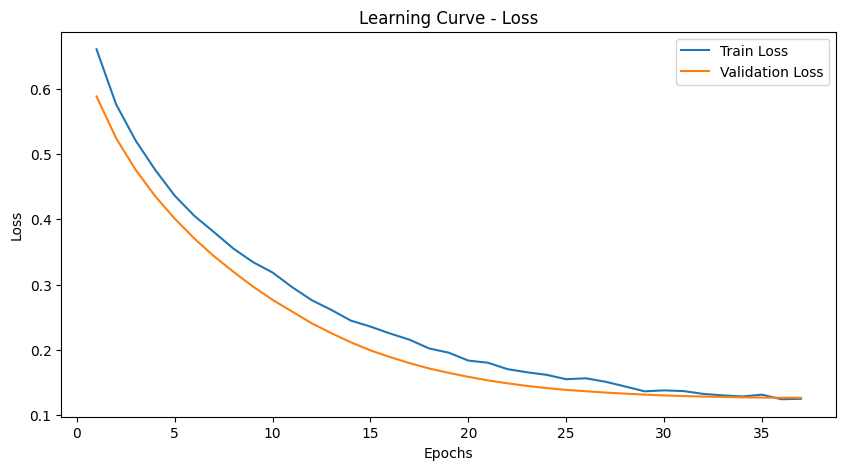

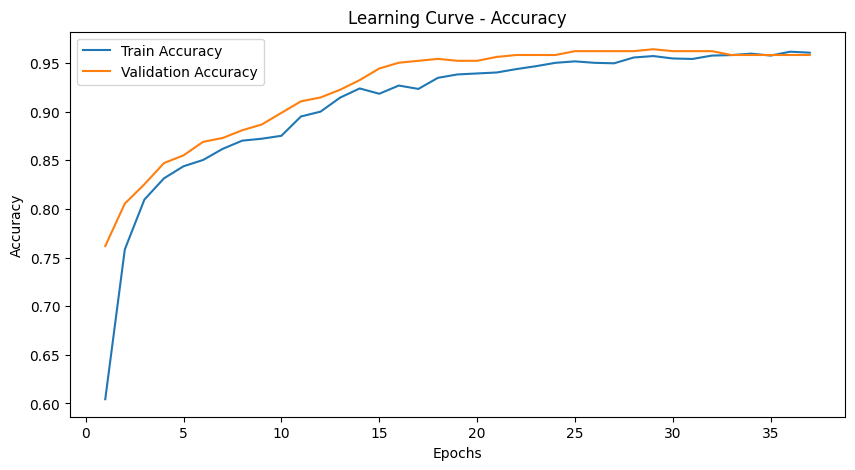

In [17]:
# Plotting learning curve for loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve - Loss')
plt.show()

# Plotting learning curve for accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve - Accuracy')
plt.show()

In [18]:
model.eval()
all_predictions = []
all_targets = []

for batch in tqdm(test_loader, desc="Evaluating on Test Data"):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    targets = batch['targets'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    predictions = torch.argmax(logits, dim=-1)
    all_predictions.extend(predictions.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

target_names = ['Negative', 'Positive']
print(classification_report(all_targets, all_predictions, target_names=target_names))

Evaluating on Test Data: 100%|█████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.45it/s]

              precision    recall  f1-score   support

    Negative       0.98      0.96      0.97       371
    Positive       0.94      0.97      0.96       258

    accuracy                           0.97       629
   macro avg       0.96      0.97      0.96       629
weighted avg       0.97      0.97      0.97       629



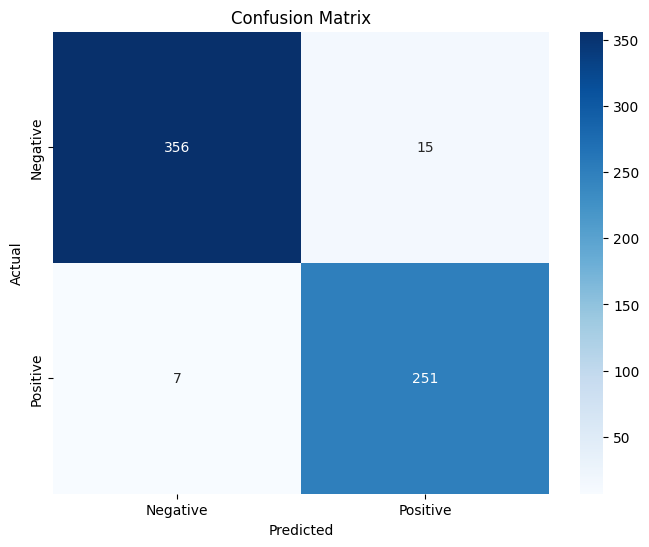

In [19]:
import seaborn as sns
conf_matrix = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Identifikasi False Positives (FP) dan False Negatives (FN)
false_positives = []
false_negatives = []

for i in range(len(all_predictions)):
    if all_predictions[i] == 1 and all_targets[i] == 0:
        false_positives.append((i, test_df.iloc[i]['review']))
    elif all_predictions[i] == 0 and all_targets[i] == 1:
        false_negatives.append((i, test_df.iloc[i]['review']))

# Menampilkan False Positives
print("\nFalse Positives (Predicted Positive, Actual Negative):")
print(f"Total False Positives: {len(false_positives)}")
for idx, review in false_positives:
    print(f"Index: {idx}, Review: {review}")

# Menampilkan False Negatives
print("\nFalse Negatives (Predicted Negative, Actual Positive):")
print(f"Total False Negatives: {len(false_negatives)}")
for idx, review in false_negatives:
    print(f"Index: {idx}, Review: {review}")



False Positives (Predicted Positive, Actual Negative):
Total False Positives: 15
Index: 8, Review: tolong permudah live kasih trafik
Index: 133, Review: bagus
Index: 134, Review: semoga sistem familiar ekpedisi bertambah pilihannya ãåââ
Index: 182, Review: belanja murah toko sebelah
Index: 191, Review: semoga dipermudahkan berjualan sinj
Index: 198, Review: perbaiki bagus aplikasinya aplikasi penghasilan jualan produk aplikasi terima kasih
Index: 205, Review: aplikasi ok
Index: 217, Review: ya mudah mudahan akun bantu bejualan
Index: 360, Review: bqik
Index: 434, Review: ya douwdlot brlm pakai barangnya toko
Index: 448, Review: membantu afiliator pemula sayajd gampang deskripsiharga promo
Index: 492, Review: gooooookd
Index: 494, Review: belibet katagori tolong berguna terima kasih
Index: 512, Review: suka
Index: 530, Review: bermanfaat

False Negatives (Predicted Negative, Actual Positive):
Total False Negatives: 7
Index: 1, Review: bahasanya tolong ganti pakai bahasa indonesia sih p

In [ ]:
# Function to predict sentiment
def predict_sentiment(review, tokenizer, model, max_len=128):
    model.eval()
    inputs = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    prediction = torch.argmax(logits, dim=-1).cpu().numpy()[0]
    return "Positif" if prediction == 1 else "Negatif"

In [ ]:
# Test the prediction function
example_reviews = [
    "upload produk hasil foto sendiri tapi kena pelanggaran",
    "tampilannya mempermudah pengguna baru"
]

for review in example_reviews:
    sentiment = predict_sentiment(review, tokenizer, model)
    print(f"Review: {review} | Sentiment: {sentiment}")

In [ ]:
# Simpan model
model_dir = "sentiment_model"
model.save_pretrained(model_dir)

# Simpan tokenizer
tokenizer_dir = "sentiment_tokenizer"
tokenizer.save_pretrained(tokenizer_dir)